In [66]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import albumentations as A
import cv2

In [67]:
cat_df = pd.read_csv('labelled_data.csv')
cat_df.head()

,img_name,features,left_eye_x,left_eye_y,right_eye_x,right_eye_y,mouth_x,mouth_y,left_ear_1_x,left_ear_1_y,left_ear_2_x,left_ear_2_y,left_ear_3_x,left_ear_3_y,right_ear_1_x,right_ear_1_y,right_ear_2_x,right_ear_2_y,right_ear_3_x,right_ear_3_y
0,00000001_000.jpg,9,175,160,239,162,199,199,149,121,137,78,166,93,281,101,312,96,296,133
1,00000001_005.jpg,9,96,96,153,127,103,146,48,20,78,-37,127,5,210,52,260,63,229,121
2,00000001_008.jpg,9,318,222,340,224,327,238,301,199,304,182,321,196,341,197,359,183,361,203
3,00000001_011.jpg,9,167,173,242,185,191,247,112,105,118,0,171,74,270,90,353,35,332,147
4,00000001_012.jpg,9,115,122,179,121,133,169,95,70,93,17,131,46,233,39,281,9,224,69


In [68]:
n = 0
img_name = cat_df.iloc[n, 0]
points = cat_df.iloc[n, 2:]
points = np.asarray(points)
points = points.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(points.shape))
print('First 4 Landmarks: {}'.format(points))

Image name: 00000001_000.jpg
Landmarks shape: (9, 2)
First 4 Landmarks: [[175. 160.]
 [239. 162.]
 [199. 199.]
 [149. 121.]
 [137.  78.]
 [166.  93.]
 [281. 101.]
 [312.  96.]
 [296. 133.]]


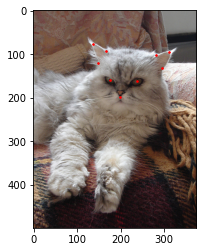

In [69]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(points[:, 0], points[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('cats/', img_name)),
               points)
plt.show()

In [72]:
#Define an Augmentation pipeline
transform = A.Compose([
    A.RandomCrop(width=224, height=224),
    A.RandomBrightnessContrast(p=0.2),
], keypoint_params=A.KeypointParams(format='xy'))

In [73]:
n = 0

img_name = cat_df.iloc[n, 0]
points = cat_df.iloc[n, 2:]
points = np.asarray(points)
points = points.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(points.shape))
keypoints = []
for point in points:
    keypoints.append((point[0], point[1]))

image = cv2.imread('cats/' + img_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transform(image=image, keypoints=keypoints)
transformed_image = transform['image']
transformed_keypoints = transform['keypoints']


Image name: 00000001_000.jpg
Landmarks shape: (9, 2)


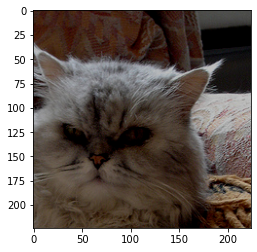

In [74]:
plt.figure()
plt.imshow(transformed_image)
plt.show()

In [75]:
transformed_points = []
for point in transformed_keypoints:
    transformed_points.append([point[0], point[1]])

transformed_points = np.asarray(transformed_points)
transformed_points

array([[ 42., 124.],
       [106., 126.],
       [ 66., 163.],
       [ 16.,  85.],
       [  4.,  42.],
       [ 33.,  57.],
       [148.,  65.],
       [179.,  60.],
       [163.,  97.]])

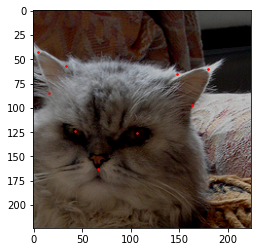

In [78]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(transformed_points[:, 0], transformed_points[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(transformed_image,
               transformed_points)
plt.show()